# How to think in JAX

<!--* freshness: { reviewed: '2024-04-08' } *-->

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax/blob/main/docs/notebooks/thinking_in_jax.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/jax-ml/jax/blob/main/docs/notebooks/thinking_in_jax.ipynb)

JAX provides a simple and powerful API for writing accelerated numerical code, but working effectively in JAX sometimes requires extra consideration. This document is meant to help build a ground-up understanding of how JAX operates, so that you can use it more effectively.

## JAX vs. NumPy

**Key concepts:**

- JAX provides a NumPy-inspired interface for convenience.
- Through duck-typing, JAX arrays can often be used as drop-in replacements of NumPy arrays.
- Unlike NumPy arrays, JAX arrays are always immutable.

The arrays themselves are implemented as different Python types:

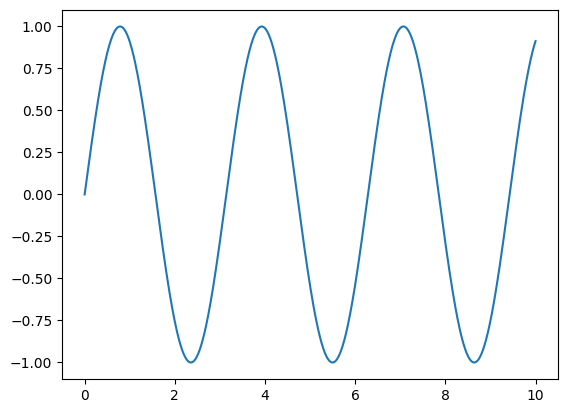

In [1]:
import numpy as np
import jax.numpy as jnp

x_np = np.linspace(0, 10, 1000)
x_jnp = jnp.linspace(0, 10, 1000)

In [3]:
type(x_np)

numpy.ndarray

In [4]:
type(x_jnp)

jaxlib._jax.ArrayImpl

Python's [duck-typing](https://en.wikipedia.org/wiki/Duck_typing) allows JAX arrays and NumPy arrays to be used interchangeably in many places.

However, there is one important difference between JAX and NumPy arrays: JAX arrays are immutable, meaning that once created their contents cannot be changed.

Here is an example of mutating an array in NumPy:

In [5]:
# NumPy: mutable arrays
x = np.arange(10)
x[0] = 10
print(x)

[10  1  2  3  4  5  6  7  8  9]


The equivalent in JAX results in an error, as JAX arrays are immutable:

In [6]:
%xmode minimal

Exception reporting mode: Minimal


In [7]:
# JAX: immutable arrays
x = jnp.arange(10)
x[0] = 10

TypeError: ignored

For updating individual elements, JAX provides an [indexed update syntax](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html#jax-numpy-ndarray-at) that returns an updated copy:

In [8]:
y = x.at[0].set(10)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[10  1  2  3  4  5  6  7  8  9]


## JAX arrays (`jax.Array`)

**Key concepts:**
- Create arrays using JAX API functions.
- JAX array objects have a `devices` attribute that indicates where the array is stored.
- JAX arrays can be *sharded* across multiple devices for parallel computation.

The default array implementation in JAX is [`jax.Array`](https://docs.jax.dev/en/latest/_autosummary/jax.Array.html#jax.Array). In many ways it is similar to
the [`numpy.ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html#numpy.ndarray) type that you may be familiar with from the NumPy package, but it
has some important differences.

### Array creation

We typically don't call the `jax.Array` constructor directly, but rather create arrays via JAX API functions.
For example, [`jax.numpy`](https://docs.jax.dev/en/latest/jax.numpy.html#module-jax.numpy) provides familiar NumPy-style array construction functionality
such as `jax.numpy.zeros`, `jax.numpy.linspace`, `jax.numpy.arange`, etc.

In [ ]:
import jax
import jax.numpy as jnp

x = jnp.arange(5)
isinstance(x, jax.Array)

If you use Python type annotations in your code, `jax.Array` is the appropriate
annotation for jax array objects (see [`jax.typing`](https://docs.jax.dev/en/latest/jax.typing.html#module-jax.typing) for more discussion).

### Array devices and sharding

JAX Array objects have a `devices` method that lets you inspect where the contents of the array are stored. In the simplest cases, this will be a single CPU device:

In [ ]:
x.devices()

In general, an array may be *sharded* across multiple devices, in a manner that can be inspected via the `sharding` attribute:

In [ ]:
x.sharding

Here the array is on a single device, but in general a JAX array can be
sharded across multiple devices, or even multiple hosts.
To read more about sharded arrays and parallel computation, refer to {ref}`sharded-computation`.

## NumPy, lax & XLA: JAX API layering

**Key concepts:**

- `jax.numpy` is a high-level wrapper that provides a familiar interface.
- `jax.lax` is a lower-level API that is stricter and often more powerful.
- All JAX operations are implemented in terms of operations in [XLA](https://www.tensorflow.org/xla/) – the Accelerated Linear Algebra compiler.

If you look at the source of `jax.numpy`, you'll see that all the operations are eventually expressed in terms of functions defined in `jax.lax`. You can think of `jax.lax` as a stricter, but often more powerful, API for working with multi-dimensional arrays.

For example, while `jax.numpy` will implicitly promote arguments to allow operations between mixed data types, `jax.lax` will not:

In [9]:
import jax.numpy as jnp
jnp.add(1, 1.0)  # jax.numpy API implicitly promotes mixed types.

Array(2., dtype=float32, weak_type=True)

In [10]:
from jax import lax
lax.add(1, 1.0)  # jax.lax API requires explicit type promotion.

TypeError: ignored

If using `jax.lax` directly, you'll have to do type promotion explicitly in such cases:

In [11]:
lax.add(jnp.float32(1), 1.0)

Array(2., dtype=float32)

Along with this strictness, `jax.lax` also provides efficient APIs for some more general operations than are supported by NumPy.

For example, consider a 1D convolution, which can be expressed in NumPy this way:

In [12]:
x = jnp.array([1, 2, 1])
y = jnp.ones(10)
jnp.convolve(x, y)

Array([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

Under the hood, this NumPy operation is translated to a much more general convolution implemented by [`lax.conv_general_dilated`](https://docs.jax.dev/en/latest/_autosummary/jax.lax.conv_general_dilated.html):

In [13]:
from jax import lax
result = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float),  # note: explicit promotion
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)])  # equivalent of padding='full' in NumPy
result[0, 0]

Array([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

This is a batched convolution operation designed to be efficient for the types of convolutions often used in deep neural nets. It requires much more boilerplate, but is far more flexible and scalable than the convolution provided by NumPy (See [Convolutions in JAX](https://docs.jax.dev/en/latest/notebooks/convolutions.html) for more detail on JAX convolutions).

At their heart, all `jax.lax` operations are Python wrappers for operations in XLA; here, for example, the convolution implementation is provided by [XLA:ConvWithGeneralPadding](https://www.tensorflow.org/xla/operation_semantics#convwithgeneralpadding_convolution).
Every JAX operation is eventually expressed in terms of these fundamental XLA operations, which is what enables just-in-time (JIT) compilation.

## To JIT or not to JIT

**Key concepts:**

- By default JAX executes operations one at a time, in sequence.
- Using a just-in-time (JIT) compilation decorator, sequences of operations can be optimized together and run at once.
- Not all JAX code can be JIT compiled, as it requires array shapes to be static & known at compile time.

The fact that all JAX operations are expressed in terms of XLA allows JAX to use the XLA compiler to execute blocks of code very efficiently.

For example, consider this function that normalizes the rows of a 2D matrix, expressed in terms of `jax.numpy` operations:

In [14]:
import jax.numpy as jnp

def norm(X):
  X = X - X.mean(0)
  return X / X.std(0)

A just-in-time compiled version of the function can be created using the `jax.jit` transform:

In [15]:
from jax import jit
norm_compiled = jit(norm)

This function returns the same results as the original, up to standard floating-point accuracy:

In [16]:
np.random.seed(1701)
X = jnp.array(np.random.rand(10000, 10))
np.allclose(norm(X), norm_compiled(X), atol=1E-6)

True

But due to the compilation (which includes fusing of operations, avoidance of allocating temporary arrays, and a host of other tricks), execution times can be orders of magnitude faster in the JIT-compiled case (note the use of `block_until_ready()` to account for JAX's [asynchronous dispatch](https://docs.jax.dev/en/latest/async_dispatch.html)):

In [18]:
%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

815 µs ± 224 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
656 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


That said, `jax.jit` does have limitations: in particular, it requires all arrays to have static shapes. That means that some JAX operations are incompatible with JIT compilation.

For example, this operation can be executed in op-by-op mode:

In [19]:
def get_negatives(x):
  return x[x < 0]

x = jnp.array(np.random.randn(10))
get_negatives(x)

Array([-0.10570311, -0.59403396, -0.8680282 , -0.23489487], dtype=float32)

But it returns an error if you attempt to execute it in jit mode:

In [20]:
jit(get_negatives)(x)

NonConcreteBooleanIndexError: ignored

This is because the function generates an array whose shape is not known at compile time: the size of the output depends on the values of the input array, and so it is not compatible with JIT.

## JIT mechanics: tracing and static variables

**Key concepts:**

- JIT and other JAX transforms work by *tracing* a function to determine its effect on inputs of a specific shape and type.

- Variables that you don't want to be traced can be marked as *static*

To use `jax.jit` effectively, it is useful to understand how it works. Let's put a few `print()` statements within a JIT-compiled function and then call the function:

In [21]:
@jit
def f(x, y):
  print("Running f():")
  print(f"  x = {x}")
  print(f"  y = {y}")
  result = jnp.dot(x + 1, y + 1)
  print(f"  result = {result}")
  return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
f(x, y)

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/0)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>


Array([0.25773212, 5.3623195 , 5.403243  ], dtype=float32)

Notice that the print statements execute, but rather than printing the data we passed to the function, though, it prints *tracer* objects that stand-in for them.

These tracer objects are what `jax.jit` uses to extract the sequence of operations specified by the function. Basic tracers are stand-ins that encode the **shape** and **dtype** of the arrays, but are agnostic to the values. This recorded sequence of computations can then be efficiently applied within XLA to new inputs with the same shape and dtype, without having to re-execute the Python code.

When we call the compiled function again on matching inputs, no re-compilation is required and nothing is printed because the result is computed in compiled XLA rather than in Python:

In [22]:
x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
f(x2, y2)

Array([1.4344584, 4.3004413, 7.9897013], dtype=float32)

The extracted sequence of operations is encoded in a JAX expression, or *jaxpr* for short. You can view the jaxpr using the `jax.make_jaxpr` transformation:

In [23]:
from jax import make_jaxpr

def f(x, y):
  return jnp.dot(x + 1, y + 1)

make_jaxpr(f)(x, y)

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }

Note one consequence of this: because JIT compilation is done *without* information on the content of the array, control flow statements in the function cannot depend on traced values. For example, this fails:

In [24]:
@jit
def f(x, neg):
  return -x if neg else x

f(1, True)

TracerBoolConversionError: ignored

If there are variables that you would not like to be traced, they can be marked as static for the purposes of JIT compilation:

In [25]:
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
  return -x if neg else x

f(1, True)

Array(-1, dtype=int32, weak_type=True)

Note that calling a JIT-compiled function with a different static argument results in re-compilation, so the function still works as expected:

In [26]:
f(1, False)

Array(1, dtype=int32, weak_type=True)

Understanding which values and operations will be static and which will be traced is a key part of using `jax.jit` effectively.